### Generic imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import math
import random
import pandas as pd
import matplotlib.image as img
import matplotlib as mpl
import numpy as np

### Create DF from dataset using images in folder

In [98]:
DATASET_TRAIN_PATH = './DataSet/train/'
DATASET_TEST_PATH = './DataSet/test/'
DATASET_SAMPLE_PATH = './DataSet/sample/'

def create_df_from_images(ds_path):
    
    files = os.scandir(ds_path)
    train = pd.DataFrame(columns=['file_name','image','nbfinger','hand'])

    for idx,file in enumerate(files):
        if not file.name.startswith('.') and file.is_file() and file.name.endswith('.png'):
            fname = file.name
            complete_fname = os.path.join(ds_path,fname)
            root,ext = os.path.splitext(fname)
            image = img.imread(complete_fname)
            flat_image = image.flatten()
            train.loc[idx,'file_name'] = fname
            train.loc[idx,'image'] = flat_image
            train.loc[idx,'nbfinger'] = root[-2:-1]
            train.loc[idx,'hand'] = root[-1:]
            
    train['nbfinger'] = train['nbfinger'].astype('category')
    train['hand'] = train['hand'].astype('category')
    return train

t1 = time.time()
train = create_df_from_images(DATASET_TRAIN_PATH)
test = create_df_from_images(DATASET_TEST_PATH)
t2 = time.time()
print('dataset created in %.2f seconds' %(t2 - t1))

dataset created in 158.04 seconds


### Data exploration

Check repartition of images among categories - should be same for all

In [99]:
train['nbfinger'].value_counts()

5    3000
4    3000
3    3000
2    3000
1    3000
0    3000
Name: nbfinger, dtype: int64

In [100]:
train['hand'].value_counts()

R    9000
L    9000
Name: hand, dtype: int64

In [101]:
train.loc[3,'image'].max()

0.8901961

### Visualization

Display random image

file_name          85b95efd-513d-45d2-8bfc-b57997e934cb_4L.png
image        [0.26666668, 0.24705882, 0.20784314, 0.2, 0.21...
nbfinger                                                     4
hand                                                         L
Name: 9478, dtype: object


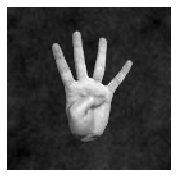

In [102]:
def plot_image(image):
    size = int(math.sqrt(len(image)))
    image_view = image.reshape(size,size)
    plt.imshow(image_view, cmap = mpl.cm.gray);
    plt.axis("off")

randidx = random.randint(0,len(train))
image = train.loc[randidx,'image']
print(train.loc[randidx,:])
plt.figure(figsize=(3,3))
plot_image(image)

Display batch images in a square matrix

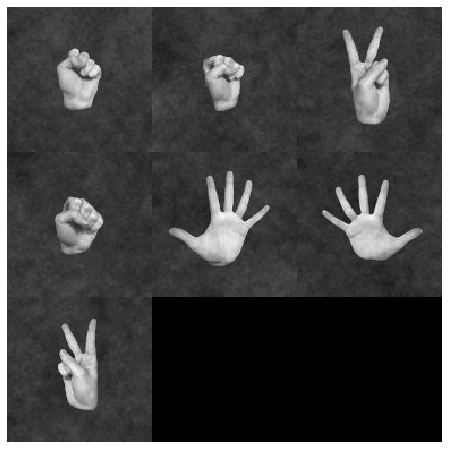

In [103]:
def plot_square_of_images(images,size=128):
    size=int(math.sqrt(len(images[0])))
    squaresize = math.ceil(math.sqrt(len(images)))
    im_row = []
    for row in range(squaresize):
        im_col=[]
        for col in range(squaresize):
            if col + squaresize * row < len(images):
                im = images.loc[col + squaresize * row]
                im = im.reshape(size,size)
            else:
                im = np.zeros((size,size))
            im_col.append(im)
        rowofimages = np.concatenate(im_col,axis=1)
        im_row.append(rowofimages)
    squareofimages = np.concatenate(im_row,axis=0)
    flat_squareofimages = squareofimages.flatten()
    plot_image(flat_squareofimages)
    
images = train.loc[:6,'image']

plt.figure(figsize=(8,8))
plot_square_of_images(images)


### Classic classifiers

In [104]:
xtrain = np.vstack(train['image'])
xtrain.shape

(18000, 16384)

In [127]:
ytrain = train['nbfinger']
ytrain.shape

(18000,)

In [107]:
xtest = np.vstack(test['image'])
xtrain = xtrain[1000:]

In [128]:
ytest = train['nbfinger']

In [129]:
# no need to scale x
xtrain_s = xtrain
xtest_s = xtest

In [130]:
xtrain_s = xtrain_s[:100]
xtest_s = xtrain_s[:20]
ytrain = ytrain[:100]
ytest = ytest[:20]

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

classifs = [KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(),
           AdaBoostClassifier(),
           GaussianNB(),
           ]

classif_names=['KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               'AdaBoost\t',
               'Naive Bayes\t',]

# Apply different classifiers

for name, clf in zip(classif_names, classifs):
    classifier = clf.fit(xtrain_s, ytrain)
    ypred = classifier.predict(xtest_s)
    score1 = classifier.score(xtest_s, ytest)*100
    score2 = accuracy_score(ypred,ytest)*100
    print("%s Score : %.2f %% %.2f" % (name, score1,score2))


KNN		 Score : 95.00 % 95.00
DecisionTree	 Score : 100.00 % 100.00
SVC		 Score : 100.00 % 100.00
RandomForest	 Score : 100.00 % 100.00
AdaBoost	 Score : 60.00 % 60.00
Naive Bayes	 Score : 100.00 % 100.00


In [132]:
print(ytest[:15])
ypred = classifier.predict(xtest_s[:15])
ypred



0     0
1     0
2     2
3     0
4     5
5     5
6     2
7     2
8     3
9     0
10    4
11    2
12    0
13    1
14    2
Name: nbfinger, dtype: category
Categories (6, object): [0, 1, 2, 3, 4, 5]


array(['0', '0', '2', '0', '5', '5', '2', '2', '3', '0', '4', '2', '0',
       '1', '2'], dtype='<U1')